In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [3]:
btc_data = yf.download('BTC-USD', start='2020-01-01', end=datetime.now().strftime('%Y-%m-%d'), progress=False)
print(f"Dataset shape: {btc_data.shape}")
print(f"Date range: {btc_data.index[0]} to {btc_data.index[-1]}")

Dataset shape: (2206, 5)
Date range: 2020-01-01 00:00:00 to 2026-01-14 00:00:00


In [4]:
btc_data.head()


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095


In [5]:
btc_data.describe()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
count,2206.000000,2206.000000,2206.000000,2206.000000,2.206000e+03
mean,47478.210538,48369.208024,46463.991035,47439.359175,3.649065e+10
std,31520.604654,31994.125798,31003.198008,31514.859457,2.159265e+10
min,4970.788086,5331.833984,4106.980957,5002.578125,5.331173e+09
25%,22355.682129,22655.295898,21621.935547,22253.975586,2.220978e+10
50%,40002.164062,41023.423828,38901.929688,39987.041016,3.204582e+10
75%,65170.951172,66482.042969,63579.439453,65132.953125,4.545657e+10
max,124752.531250,126198.070312,123196.046875,124752.140625,3.509679e+11


In [6]:
print("Missing values:")
print(btc_data.isnull().sum())

Missing values:
Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
dtype: int64


In [ ]:
close_prices = btc_data.loc[:, 'Close'].iloc[:, 0]

current_price = float(close_prices.iloc[-1])
highest_price = float(close_prices.max())
lowest_price  = float(close_prices.min())

print(f"💰 Current Bitcoin Price: ${current_price:,.2f}")
print(f"📈 Highest Price: ${highest_price:,.2f}")
print(f"📉 Lowest Price: ${lowest_price:,.2f}")

💰 Current Bitcoin Price: $96,929.33
📈 Highest Price: $124,752.53
📉 Lowest Price: $4,970.79


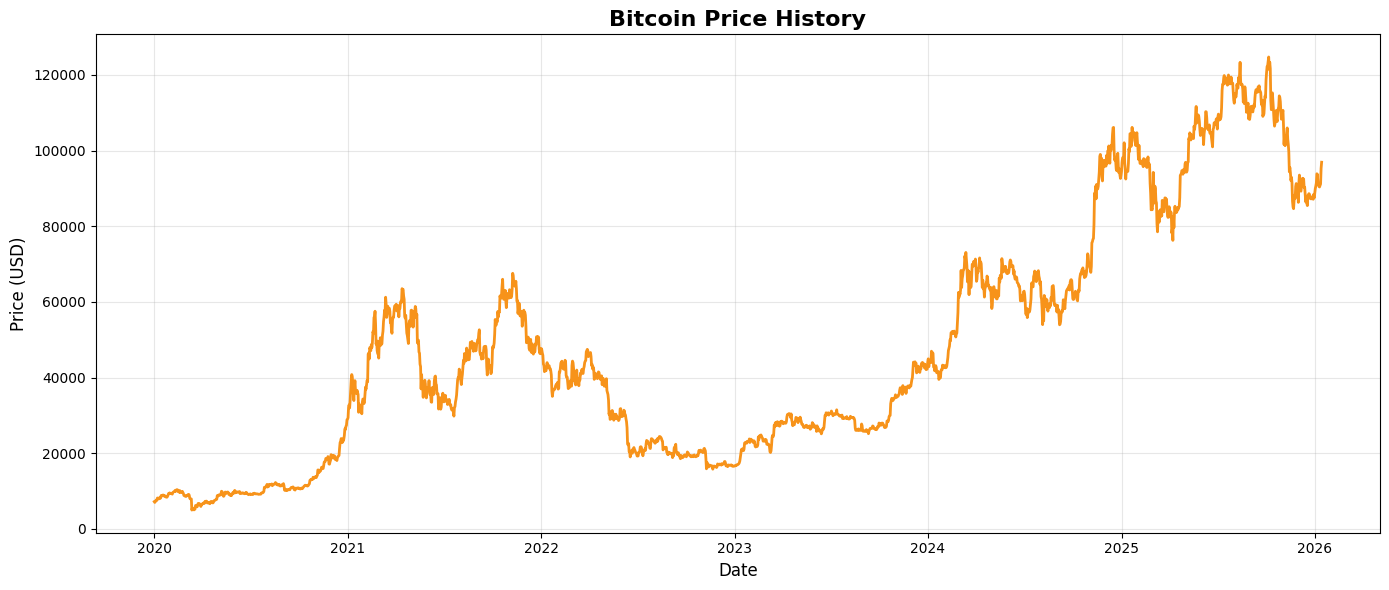

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(btc_data.index, btc_data['Close'], linewidth=2, color='#f7931a')
plt.title('Bitcoin Price History', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

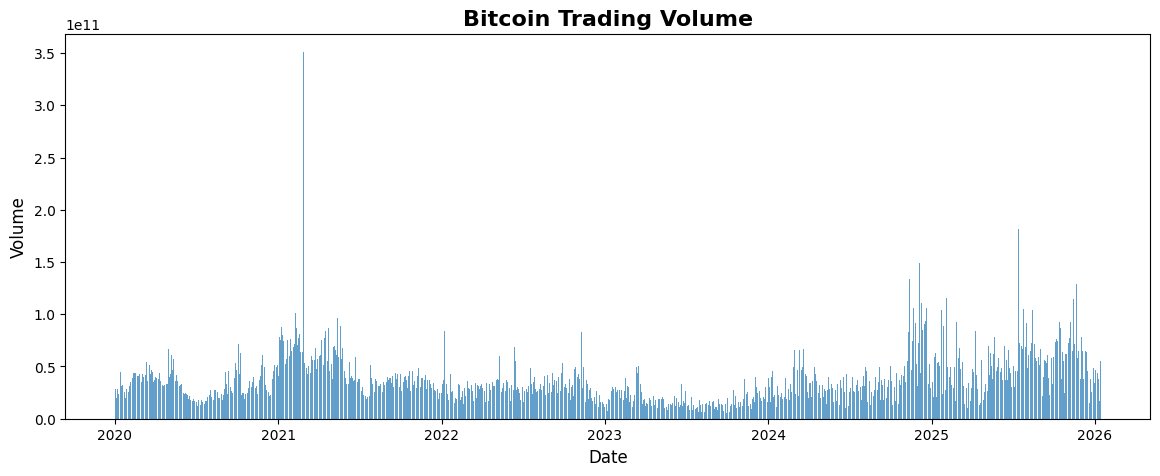

In [ ]:
volume = btc_data.loc[:, 'Volume'].iloc[:, 0]

plt.figure(figsize=(14, 5))
plt.bar(btc_data.index, volume, alpha=0.7)
plt.title('Bitcoin Trading Volume', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.show()

In [14]:
def create_features(df, lookback=7):
    """Create technical indicators and features for ML models"""
    df = df.copy()
    
    # Moving averages
    df['MA_7'] = df['Close'].rolling(window=7).mean()
    df['MA_30'] = df['Close'].rolling(window=30).mean()
    df['MA_90'] = df['Close'].rolling(window=90).mean()
    
    # Volatility
    df['Volatility'] = df['Close'].rolling(window=7).std()
    
    # Price changes
    df['Price_Change'] = df['Close'].pct_change()
    df['Volume_Change'] = df['Volume'].pct_change()
    
    # Lagged features
    for i in range(1, lookback + 1):
        df[f'Close_Lag_{i}'] = df['Close'].shift(i)
        df[f'Volume_Lag_{i}'] = df['Volume'].shift(i)
    
    # RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    
    # Drop NaN values
    df = df.dropna()
    
    return df

# Create features
print("Creating features...")
btc_features = create_features(btc_data, lookback=7)
print(f"✅ Created {len(btc_features.columns)} features")
print(f"Dataset shape after feature engineering: {btc_features.shape}")

Creating features...
✅ Created 27 features
Dataset shape after feature engineering: (2117, 27)


In [15]:
btc_features.head()

Price,Close,High,Low,Open,Volume,MA_7,MA_30,MA_90,Volatility,Price_Change,...,Close_Lag_4,Volume_Lag_4,Close_Lag_5,Volume_Lag_5,Close_Lag_6,Volume_Lag_6,Close_Lag_7,Volume_Lag_7,RSI,MACD
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,6429.841797,6517.195801,5903.234375,5925.538574,37101651525,6456.597726,6885.428499,8288.013146,296.622488,0.085747,...,6716.440430,3.531980e+10,6681.062988,4.459011e+10,6734.803711,4.822191e+10,6416.314941,4.649192e+10,68.387602,-408.317935
2020-03-31,6438.644531,6504.515137,6374.162109,6430.606445,32786468812,6414.289272,6814.634847,8279.551704,270.278595,0.001369,...,6469.798340,3.458560e+10,6716.440430,3.531980e+10,6681.062988,4.459011e+10,6734.803711,4.822191e+10,66.633332,-369.572955
2020-04-01,6606.776367,6612.573730,6202.373535,6437.319336,40346426266,6403.676897,6739.205062,8275.343994,259.293213,0.026113,...,6242.193848,3.488523e+10,6469.798340,3.458560e+10,6716.440430,3.531980e+10,6681.062988,4.459011e+10,67.996579,-321.593318
2020-04-02,6793.624512,7088.247559,6595.918457,6606.776367,47660646124,6414.703195,6672.733008,8269.218886,275.918128,0.028281,...,5922.042969,2.837369e+10,6242.193848,3.488523e+10,6469.798340,3.458560e+10,6716.440430,3.531980e+10,59.922271,-265.432288
2020-04-03,6733.387207,7003.220703,6673.335938,6797.396484,38976504903,6452.358747,6605.337712,8261.693669,301.491659,-0.008867,...,6429.841797,3.710165e+10,5922.042969,2.837369e+10,6242.193848,3.488523e+10,6469.798340,3.458560e+10,58.655092,-223.211867


In [16]:
print("Feature columns:")
print(list(btc_features.columns))

Feature columns:
[('Close', 'BTC-USD'), ('High', 'BTC-USD'), ('Low', 'BTC-USD'), ('Open', 'BTC-USD'), ('Volume', 'BTC-USD'), ('MA_7', ''), ('MA_30', ''), ('MA_90', ''), ('Volatility', ''), ('Price_Change', ''), ('Volume_Change', ''), ('Close_Lag_1', ''), ('Volume_Lag_1', ''), ('Close_Lag_2', ''), ('Volume_Lag_2', ''), ('Close_Lag_3', ''), ('Volume_Lag_3', ''), ('Close_Lag_4', ''), ('Volume_Lag_4', ''), ('Close_Lag_5', ''), ('Volume_Lag_5', ''), ('Close_Lag_6', ''), ('Volume_Lag_6', ''), ('Close_Lag_7', ''), ('Volume_Lag_7', ''), ('RSI', ''), ('MACD', '')]


In [18]:
def prepare_data(df, target_days=1):
    """Prepare features and target variable"""
    # Create target (future price)
    df['Target'] = df['Close'].shift(-target_days)
    df = df.dropna()
    
    # Select features (exclude price columns and target)
    feature_cols = [col for col in df.columns 
                   if col not in ['Target', 'Close', 'Open', 'High', 'Low', 'Adj Close']]
    
    X = df[feature_cols]
    y = df['Target']
    
    return X, y, df.index
    
# Prepare data (predict 1 day ahead)
PREDICTION_DAYS = 1
X, y, dates = prepare_data(btc_features, target_days=PREDICTION_DAYS)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (2116, 28)
Target shape: (2116,)


In [19]:
X.head()

Price,Close,High,Low,Open,Volume,MA_7,MA_30,MA_90,Volatility,Price_Change,...,Volume_Lag_4,Close_Lag_5,Volume_Lag_5,Close_Lag_6,Volume_Lag_6,Close_Lag_7,Volume_Lag_7,RSI,MACD,Target
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,6429.841797,6517.195801,5903.234375,5925.538574,37101651525,6456.597726,6885.428499,8288.013146,296.622488,0.085747,...,3.531980e+10,6681.062988,4.459011e+10,6734.803711,4.822191e+10,6416.314941,4.649192e+10,68.387602,-408.317935,6438.644531
2020-03-31,6438.644531,6504.515137,6374.162109,6430.606445,32786468812,6414.289272,6814.634847,8279.551704,270.278595,0.001369,...,3.458560e+10,6716.440430,3.531980e+10,6681.062988,4.459011e+10,6734.803711,4.822191e+10,66.633332,-369.572955,6606.776367
2020-04-01,6606.776367,6612.573730,6202.373535,6437.319336,40346426266,6403.676897,6739.205062,8275.343994,259.293213,0.026113,...,3.488523e+10,6469.798340,3.458560e+10,6716.440430,3.531980e+10,6681.062988,4.459011e+10,67.996579,-321.593318,6793.624512
2020-04-02,6793.624512,7088.247559,6595.918457,6606.776367,47660646124,6414.703195,6672.733008,8269.218886,275.918128,0.028281,...,2.837369e+10,6242.193848,3.488523e+10,6469.798340,3.458560e+10,6716.440430,3.531980e+10,59.922271,-265.432288,6733.387207
2020-04-03,6733.387207,7003.220703,6673.335938,6797.396484,38976504903,6452.358747,6605.337712,8261.693669,301.491659,-0.008867,...,3.710165e+10,5922.042969,2.837369e+10,6242.193848,3.488523e+10,6469.798340,3.458560e+10,58.655092,-223.211867,6867.527344


In [20]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
test_dates = dates[split_idx:]

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Train period: {dates[0]} to {dates[split_idx-1]}")
print(f"Test period: {dates[split_idx]} to {dates[-1]}")

Training set: 1692 samples
Test set: 424 samples
Train period: 2020-03-30 00:00:00 to 2024-11-15 00:00:00
Test period: 2024-11-16 00:00:00 to 2026-01-13 00:00:00


In [21]:
# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled successfully!")

✅ Features scaled successfully!


In [22]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'mse': mse,
        'mae': mae,
        'r2': r2
    }
    
    print(f"\n{name} Results:")
    print(f"  MSE: ${mse:,.2f}")
    print(f"  MAE: ${mae:,.2f}")
    print(f"  R² Score: {r2:.4f}")

print(f"\n{'='*50}")
print("✅ All models trained successfully!")


Training Linear Regression...

Linear Regression Results:
  MSE: $0.00
  MAE: $0.00
  R² Score: 1.0000

Training Random Forest...

Random Forest Results:
  MSE: $305,697,572.20
  MAE: $14,322.94
  R² Score: -1.4510

✅ All models trained successfully!


In [23]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MSE': [results[m]['mse'] for m in results.keys()],
    'MAE': [results[m]['mae'] for m in results.keys()],
    'R² Score': [results[m]['r2'] for m in results.keys()]
})

print("\n📊 Model Comparison:")
print(comparison_df.to_string(index=False))


📊 Model Comparison:
            Model          MSE          MAE  R² Score
Linear Regression 6.842188e-22 2.374982e-11  1.000000
    Random Forest 3.056976e+08 1.432294e+04 -1.450977


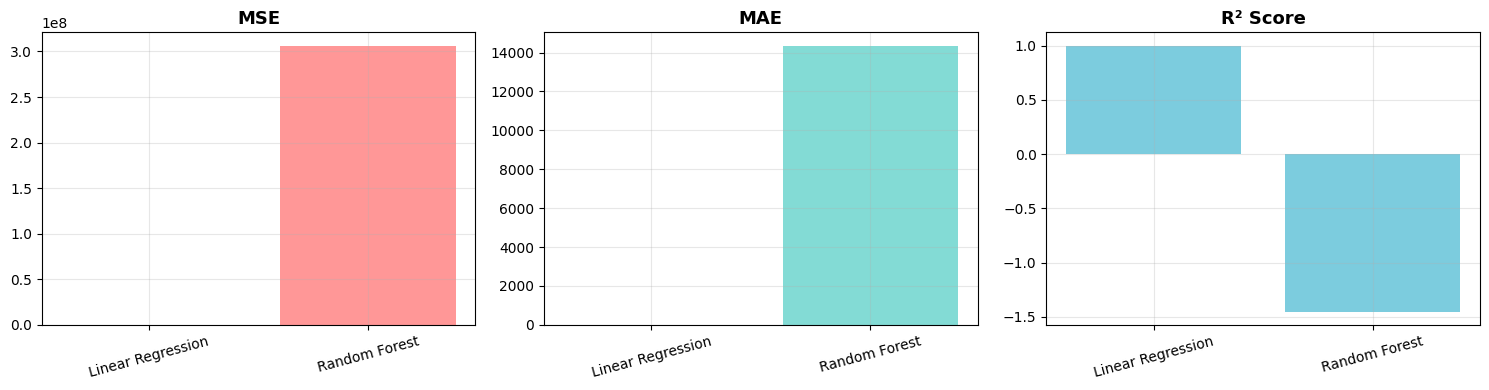

In [24]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['MSE', 'MAE', 'R² Score']
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']

for idx, metric in enumerate(metrics):
    axes[idx].bar(comparison_df['Model'], comparison_df[metric], color=colors[idx], alpha=0.7)
    axes[idx].set_title(metric, fontsize=13, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=15)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# ## 9. Visualize Predictions

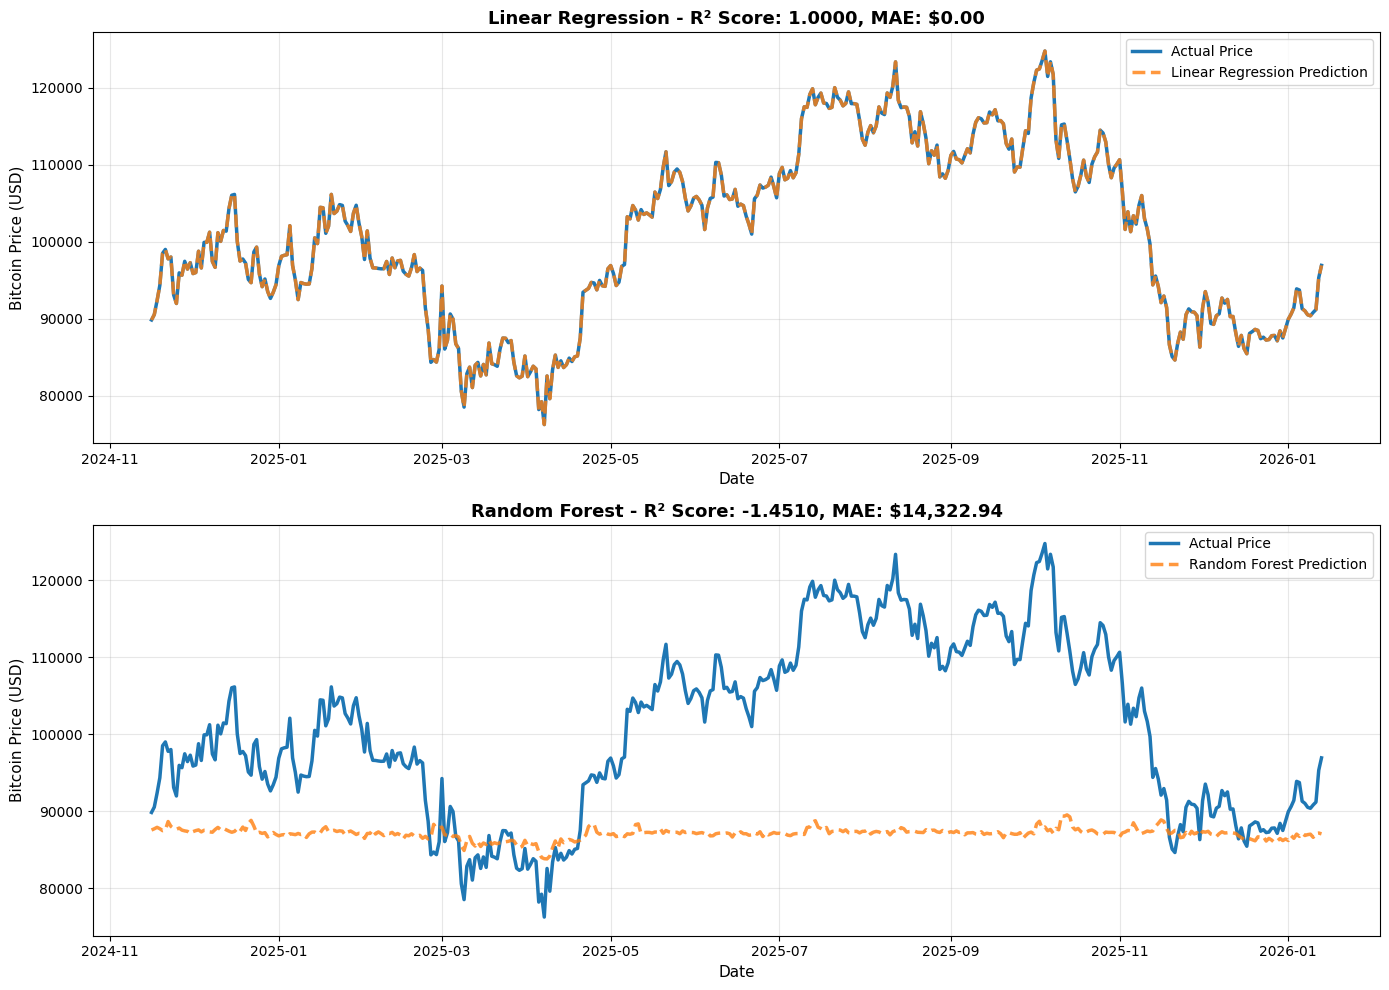

In [26]:
# Plot predictions for both models
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx]
    
    ax.plot(test_dates, y_test.values, label='Actual Price', linewidth=2.5, color='#1f77b4')
    ax.plot(test_dates, result['predictions'], label=f'{name} Prediction', 
            linewidth=2.5, color='#ff7f0e', alpha=0.8, linestyle='--')
    
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Bitcoin Price (USD)', fontsize=11)
    ax.set_title(f'{name} - R² Score: {result["r2"]:.4f}, MAE: ${result["mae"]:,.2f}', 
                fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Get feature importance from Random Forest
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🎯 Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))


🎯 Top 10 Most Important Features:
         Feature  Importance
      (Target, )    0.981483
(Close, BTC-USD)    0.002535
 (High, BTC-USD)    0.002222
 (Close_Lag_1, )    0.001796
 (Open, BTC-USD)    0.001772
        (MA_7, )    0.001615
       (MA_30, )    0.001494
 (Close_Lag_2, )    0.001260
       (MA_90, )    0.001062
 (Close_Lag_5, )    0.000922


In [ ]:
# Plot feature importance
top_features['Feature'] = top_features['Feature'].apply(
    lambda x: ' '.join(map(str, x)) if isinstance(x, tuple) else str(x)
)

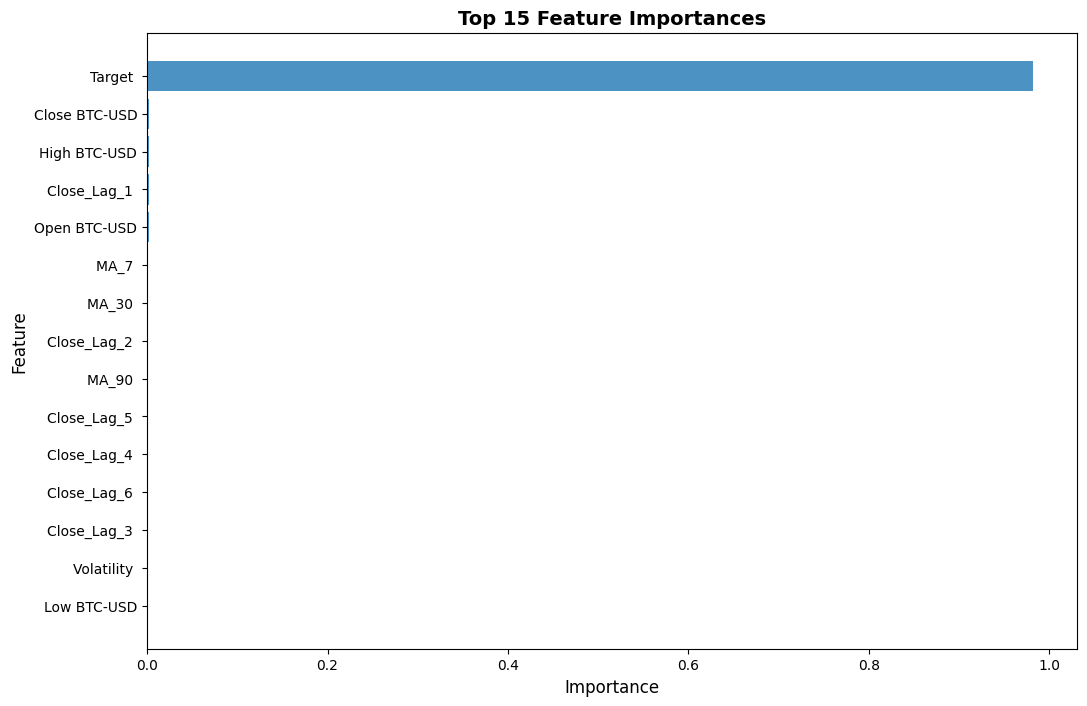

In [30]:
plt.figure(figsize=(12, 8))
plt.barh(
    top_features['Feature'],
    top_features['Importance'],
    alpha=0.8
)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.show()

In [31]:
# Calculate prediction errors for Random Forest
rf_predictions = results['Random Forest']['predictions']
errors = y_test.values - rf_predictions
error_percentage = (errors / y_test.values) * 100

print(f"Mean Prediction Error: ${np.mean(np.abs(errors)):,.2f}")
print(f"Mean Error Percentage: {np.mean(np.abs(error_percentage)):.2f}%")
print(f"Median Prediction Error: ${np.median(np.abs(errors)):,.2f}")
print(f"Max Prediction Error: ${np.max(np.abs(errors)):,.2f}")

Mean Prediction Error: $14,322.94
Mean Error Percentage: 13.30%
Median Prediction Error: $13,410.05
Max Prediction Error: $36,789.31


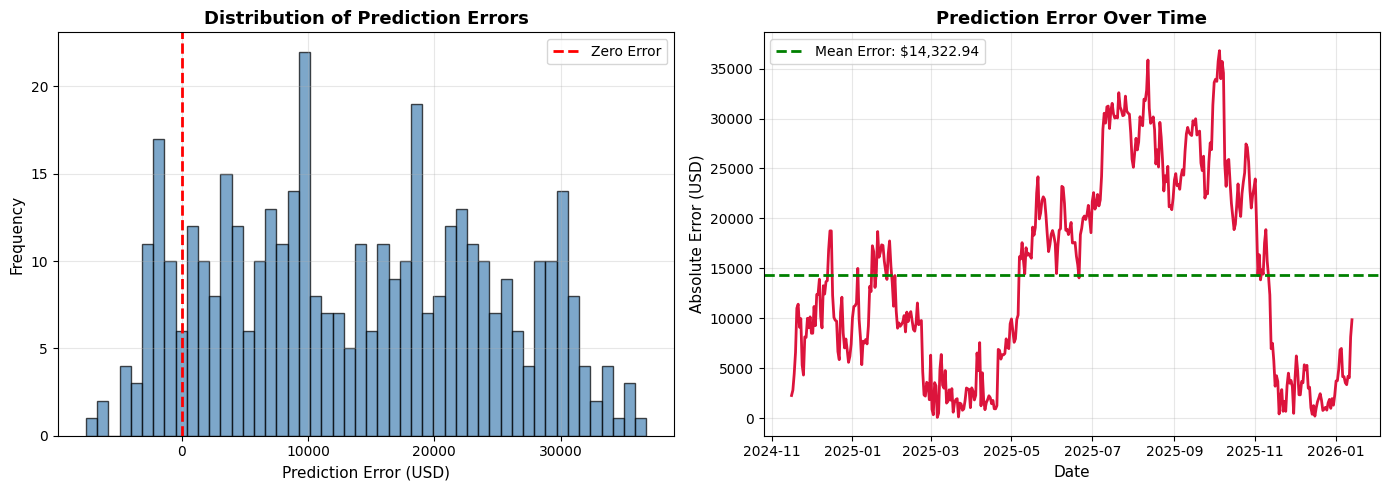

In [32]:
# Plot prediction errors
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error distribution
axes[0].hist(errors, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_xlabel('Prediction Error (USD)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Prediction Errors', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error over time
axes[1].plot(test_dates, np.abs(errors), color='crimson', linewidth=2)
axes[1].axhline(y=np.mean(np.abs(errors)), color='green', linestyle='--', 
               linewidth=2, label=f'Mean Error: ${np.mean(np.abs(errors)):,.2f}')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Absolute Error (USD)', fontsize=11)
axes[1].set_title('Prediction Error Over Time', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:
import pickle

# Save the best model (Random Forest)
best_model = results['Random Forest']['model']

# Save model and scaler
with open('bitcoin_rf_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and scaler saved successfully!")
print("bitcoin_rf_model.pkl")
print("scaler.pkl")

Model and scaler saved successfully!
bitcoin_rf_model.pkl
scaler.pkl
